In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
from scipy.spatial.distance import cdist
import time
import multiprocessing as mp
from itertools import product
import copy
from scipy.optimize import minimize

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Path definitions
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = None
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

dataset = "2020-10-06-7"
estim = "data003/data003-all"
estim_1elec = "data001"
wnoise = "kilosort_data000/data000"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)

p = 2
cell = 259

### DATA CLEANING ###

X_expt_orig, probs_orig, T_orig = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, cell,
                                           load_from_mat=True, 
                                           MATFILE_BASE=MATFILE_BASE)
X_all = mutils.get_stim_amps_newlv(electrical_path, p)

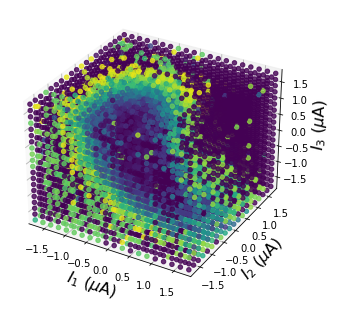

In [3]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=probs_orig, s=20, alpha=0.8, vmin=0, vmax=1)

In [4]:
def get_performance_AL(X, probs_expt, params):
    probs_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X, has_constant='add'),
                                             params)

    RMSE = np.sqrt(np.sum((probs_pred - probs_expt)**2) / len(X))

    return RMSE

In [5]:
def get_R2_AL(X, probs_expt, trials, params):
    X_bin, y_bin = fitting.convertToBinaryClassifier(probs_expt, trials, X)

    ybar = np.mean(y_bin)
    beta_null = np.log(ybar / (1 - ybar))
    null_weights = np.concatenate((np.array([beta_null]), np.zeros(X.shape[-1])))
    nll_null = fitting.negLL_hotspot(null_weights, X_bin, y_bin, False, 'none', 0)

    nll_opt = fitting.negLL_hotspot(params, X_bin, y_bin, False, 'none', 0)

    return 1 - nll_opt / nll_null

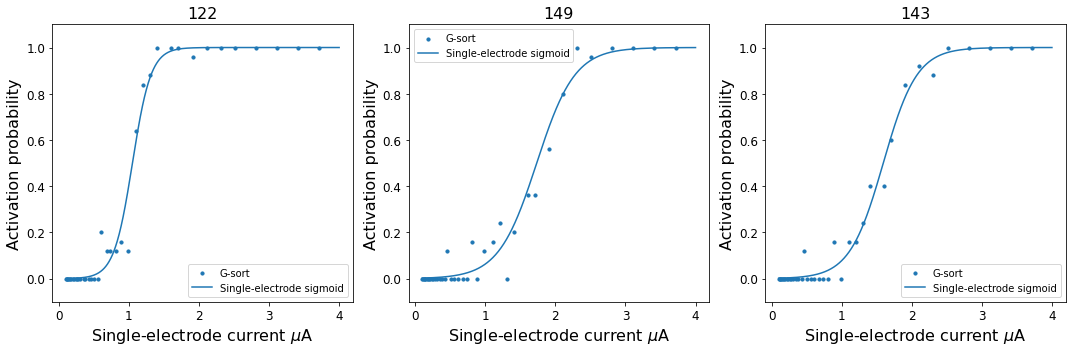

In [6]:
triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)

SE_params = np.zeros((len(triplet_elecs), 2))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for j in range(len(triplet_elecs)):
    currs_1d, Ivals, sigmoid, probs_1elec, params = mutils.get1elecCurve(dataset, gsort_path_1elec, estim_1elec, wnoise, 
                                                        triplet_elecs[j], cell, spont_limit=0.2, return_params=True)

    SE_params[j] = params
    axs[j].scatter(Ivals[:len(probs_1elec)], probs_1elec, s=10, label='G-sort')
    axs[j].plot(currs_1d, sigmoid, label='Single-electrode sigmoid')
    axs[j].set_xlabel(r'Single-electrode current $\mu$A', fontsize=16)
    axs[j].set_ylabel(r'Activation probability', fontsize=16)
    axs[j].tick_params(labelsize=12)
    axs[j].set_ylim(-0.1, 1.1)
    axs[j].legend(fontsize=10)
    axs[j].set_title(str(triplet_elecs[j]), fontsize=16)

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.show()

thresholds = -SE_params[:, 0] / SE_params[:, 1]
weights_1elec = np.concatenate((np.array([SE_params[np.argmin(thresholds), 0]]), 
                            SE_params[:, 1] / SE_params[:, 0] * SE_params[np.argmin(thresholds), 0]))
weights_1elec_neg = np.concatenate((np.array([SE_params[np.argmin(thresholds), 0]]), 
                            -SE_params[:, 1] / SE_params[:, 0] * SE_params[np.argmin(thresholds), 0]))
params_1elec = np.vstack((weights_1elec, weights_1elec_neg))

In [7]:
k = 1

new_weights = []
for i in range(len(SE_params)):
    weight = np.zeros(len(SE_params)+1)
    weight[0] = SE_params[i][0]
    weight[k] = SE_params[i][1]

    weight_neg = np.zeros(len(SE_params)+1)
    weight_neg[0] = SE_params[i][0]
    weight_neg[k] = -SE_params[i][1]

    new_weights.append(weight)
    new_weights.append(weight_neg)
    k += 1

new_weights = np.array(new_weights)

In [8]:
combos = fitting.all_combos(np.arange(len(SE_params), dtype=int))
new_weights_2elec = []
for i in range(len(combos)):
    if len(combos[i]) == 2:
        weight = np.zeros(len(SE_params)+1)
        weight_neg = np.zeros(len(SE_params)+1)
        combo = np.array(combos[i])
        thresholds_combo = -SE_params[combo, 0] / SE_params[combo, 1]

        weight[0] = SE_params[combo[np.argmin(thresholds_combo)], 0]
        weight[combo + 1] = SE_params[combo, 1] / SE_params[combo, 0] * SE_params[combo[np.argmin(thresholds_combo)], 0]

        weight_neg[0] = SE_params[combo[np.argmin(thresholds_combo)], 0]
        weight_neg[combo + 1] = -SE_params[combo, 1] / SE_params[combo, 0] * SE_params[combo[np.argmin(thresholds_combo)], 0]

        new_weights_2elec.append(weight)
        new_weights_2elec.append(weight_neg)

new_weights_2elec = np.array(new_weights_2elec)

In [9]:
params_1elec_nonlinear = np.vstack((params_1elec, new_weights, new_weights_2elec))

In [10]:
params_1elec_nonlinear

array([[-7.94400119,  7.56537875,  4.58356888,  4.98735052],
       [-7.94400119, -7.56537875, -4.58356888, -4.98735052],
       [-7.94400119,  7.56537875,  0.        ,  0.        ],
       [-7.94400119, -7.56537875,  0.        ,  0.        ],
       [-6.36518764,  0.        ,  3.67261727,  0.        ],
       [-6.36518764,  0.        , -3.67261727,  0.        ],
       [-6.62873309,  0.        ,  0.        ,  4.16160756],
       [-6.62873309,  0.        ,  0.        , -4.16160756],
       [-7.94400119,  7.56537875,  4.58356888,  0.        ],
       [-7.94400119, -7.56537875, -4.58356888,  0.        ],
       [-7.94400119,  7.56537875,  0.        ,  4.98735052],
       [-7.94400119, -7.56537875,  0.        , -4.98735052],
       [-6.62873309,  0.        ,  3.82467902,  4.16160756],
       [-6.62873309,  0.        , -3.82467902, -4.16160756]])

In [11]:
surf_1elec = fitting.sigmoidND_nonlinear(sm.add_constant(X_expt_orig, has_constant='add'), params_1elec_nonlinear)

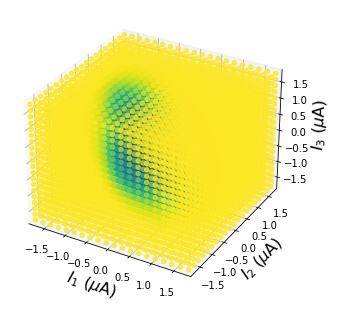

In [12]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=surf_1elec, 
            s=20, alpha=0.8, vmin=0, vmax=1)

In [13]:
method = 'L-BFGS-B'
jac = fitting.negLL_hotspot_jac
l2_reg = 0.1

X_expt, probs, T = mutils.triplet_cleaning(X_expt_orig, probs_orig, T_orig, electrical_path, p)
params_full = fitting.fit_triplet_surface(X_expt, probs, T, method=method, jac=jac, starting_m=4, max_sites=4, reg_method='l2', 
                                          reg=l2_reg)
performance_full = get_performance_AL(X_expt, probs, params_full)
R2_full = get_R2_AL(X_expt, probs, T, params_full)

In [14]:
params_full

array([[-5.98518703, -2.28059343, -2.93318542, -4.30999846],
       [-5.98518703, -0.25673215,  2.89089004,  3.80729538],
       [-5.98518703, -5.73828376, -1.36034227, -0.05977443],
       [-5.98518703,  5.39552879,  1.95280921,  1.80322848]])

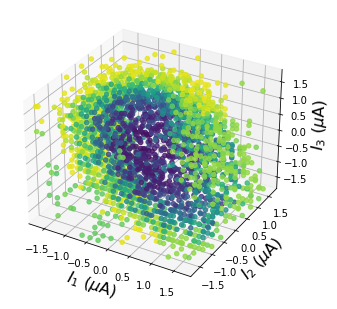

In [15]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt[:, 0], 
            X_expt[:, 1],
            X_expt[:, 2], marker='o', c=probs, s=20, alpha=0.8, vmin=0, vmax=1)

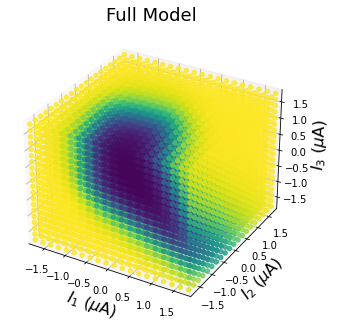

In [16]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.title('Full Model', fontsize=18)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'), params_full), 
            s=20, alpha=0.8, vmin=0, vmax=1)


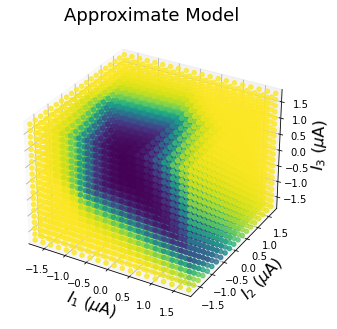

In [17]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.title('Approximate Model', fontsize=18)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=fitting.sigmoidND_nonlinear_max(sm.add_constant(X_all, has_constant='add'), params_full), 
            s=20, alpha=0.8, vmin=0, vmax=1)

In [18]:
X_l = sm.add_constant(X_expt, has_constant='add')
X_u = sm.add_constant(X_all, has_constant='add')

In [19]:
variances = fitting.var_max(X_l, X_u, params_full, l2_reg=l2_reg)

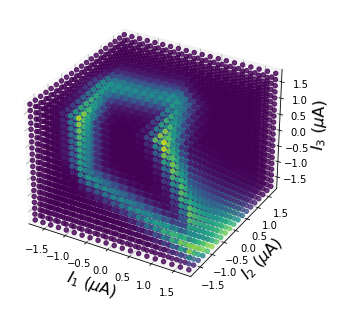

In [20]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=variances, 
            s=20, alpha=0.8)

In [21]:
get_performance_AL(X_expt, probs, params_1elec_nonlinear), get_R2_AL(X_expt, probs, T, params_1elec_nonlinear)

(0.34006110637566933, -1.1043577981194757)

In [22]:
performance_full, R2_full

(0.10780076268270902, 0.24716469131203567)

In [23]:
params_1elec

array([[-7.94400119,  7.56537875,  4.58356888,  4.98735052],
       [-7.94400119, -7.56537875, -4.58356888, -4.98735052]])

In [24]:
params_full

array([[-5.98518703, -2.28059343, -2.93318542, -4.30999846],
       [-5.98518703, -0.25673215,  2.89089004,  3.80729538],
       [-5.98518703, -5.73828376, -1.36034227, -0.05977443],
       [-5.98518703,  5.39552879,  1.95280921,  1.80322848]])

In [25]:
bound_1elec = 0.49999
init_size = 100

inds_1elec = np.where(np.absolute(surf_1elec - 0.5) <= bound_1elec)[0]
init_inds = np.random.choice(inds_1elec, replace=False, size=init_size)

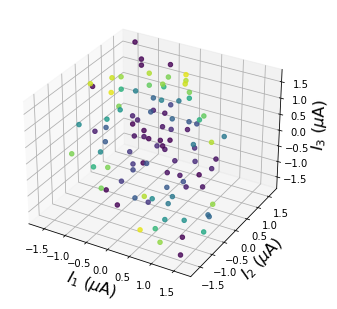

In [26]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[init_inds, 0], 
            X_expt_orig[init_inds, 1],
            X_expt_orig[init_inds, 2], marker='o', c=probs_orig[init_inds], s=20, alpha=0.8, vmin=0, vmax=1)

## Option 2: Use previous fit for D&D

In [30]:
noise_thr = 0.15
zero_prob = 0.01
batch_size = 20

# exploit = 0.5
# exploit_batch = int(exploit * batch_size)
# explore_batch = batch_size - exploit_batch

max_samples = 500
flip_thr = 0.5
bound_1elec = 0.49999
init_size = 100
inds_1elec = np.where(np.absolute(surf_1elec - 0.5) <= bound_1elec)[0]

method = 'L-BFGS-B'
jac = fitting.negLL_hotspot_jac

num_restarts = 100

performance_stack = []
performance_stack_random = []

for restart in range(num_restarts):
    print(restart+1)
    init_inds = np.random.choice(inds_1elec, replace=False, size=init_size)
    curr_inds = init_inds
    remaining_inds = np.setdiff1d(np.arange(len(X_expt_orig), dtype=int), init_inds)

    # fig = plt.figure(0)
    # fig.clear()
    # ax = Axes3D(fig, auto_add_to_figure=False)
    # fig.add_axes(ax)
    # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    # plt.xlim(-1.8, 1.8)
    # plt.ylim(-1.8, 1.8)

    # ax.set_zlim(-1.8, 1.8)
    # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    # scat = ax.scatter(X_expt_orig[init_inds, 0], 
    #             X_expt_orig[init_inds, 1],
    #             X_expt_orig[init_inds, 2], marker='o', c=probs_orig[init_inds], s=20, alpha=0.8, vmin=0, vmax=1)

    curr_inds_random = curr_inds
    remaining_inds_random = remaining_inds

    performances = []
    performances_random = []

    num_samples = []
    while True:
        num_samples.append(len(curr_inds))
        if len(curr_inds) == len(init_inds):
            good_inds = np.where(probs_orig[curr_inds] >= noise_thr)[0]
            
            start_inds = curr_inds[good_inds]
            X_sub, probs_sub, T_sub = X_expt_orig[start_inds], probs_orig[start_inds], T_orig[start_inds]
            X_sub_random, probs_sub_random, T_sub_random = X_sub, probs_sub, T_sub

            curr_params = fitting.fit_triplet_surface(X_sub, probs_sub, T_sub, method=method, jac=jac, 
                                                  starting_m=4, max_sites=4, reg_method='l2', 
                                                  reg=l2_reg)
                                                  
            curr_params_random = fitting.fit_triplet_surface(X_sub_random, probs_sub_random, T_sub_random, method=method, jac=jac, 
                                                  starting_m=4, max_sites=4, reg_method='l2', 
                                                  reg=l2_reg)

        else:
            X_sub, probs_sub, T_sub = X_expt_orig[curr_inds], probs_orig[curr_inds], T_orig[curr_inds]
            X_sub_random, probs_sub_random, T_sub_random = X_expt_orig[curr_inds_random], probs_orig[curr_inds_random], T_orig[curr_inds_random]


            low_inds = np.where(probs_sub <= noise_thr)[0]
            low_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub[low_inds], has_constant='add'), last_fit)
            probs_sub[low_inds[np.where(low_pred > flip_thr)[0]]] = 1

            low_inds_random = np.where(probs_sub_random <= noise_thr)[0]
            low_pred_random = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub_random[low_inds_random], has_constant='add'), last_fit_random)
            probs_sub_random[low_inds_random[np.where(low_pred_random > flip_thr)[0]]] = 1

            curr_params = fitting.fit_triplet_surface(X_sub, probs_sub, T_sub, method=method, jac=jac, 
                                                  starting_m=4, max_sites=4, reg_method='l2', 
                                                  reg=l2_reg, initialization=last_fit)

            curr_params_random = fitting.fit_triplet_surface(X_sub_random, probs_sub_random, T_sub_random, method=method, jac=jac, 
                                                  starting_m=4, max_sites=4, reg_method='l2', 
                                                  reg=l2_reg, initialization=last_fit_random)

        # fig = plt.figure(1)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)

        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_sub[:, 0], 
        #             X_sub[:, 1],
        #             X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

        

        # good_inds = np.where(probs_sub >= noise_thr)[0]
        # good_inds_random = np.where(probs_sub_random >= noise_thr)[0]

        # X_sub, probs_sub, T_sub = X_sub[good_inds], probs_sub[good_inds], T_sub[good_inds]
        # X_sub_random, probs_sub_random, T_sub_random = X_sub_random[good_inds_random], probs_sub_random[good_inds_random], T_sub_random[good_inds_random]

        # fig = plt.figure(1)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)

        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_sub[:, 0], 
        #             X_sub[:, 1],
        #             X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

        
        curr_R2 = get_R2_AL(X_expt, probs, T, curr_params)
        curr_performance = get_performance_AL(X_expt, probs, curr_params)
        
        curr_R2_random = get_R2_AL(X_expt, probs, T, curr_params_random)
        curr_performance_random = get_performance_AL(X_expt, probs, curr_params_random)

        # print(curr_params, curr_params_random)

        print(curr_R2, curr_R2_random, curr_performance, curr_performance_random)
        performances.append(curr_performance)
        performances_random.append(curr_performance_random)
        curr_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
                                                    curr_params)
        curr_pred_random = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
                                                    curr_params_random)

        last_fit = curr_params
        last_fit_random = curr_params_random

        variances = fitting.var_max(sm.add_constant(X_sub, has_constant='add'),
                                    sm.add_constant(X_expt_orig[remaining_inds], has_constant='add'),
                                    curr_params,
                                    l2_reg=l2_reg)

        if len(curr_inds) >= max_samples:
            # fig = plt.figure(2)
            # fig.clear()
            # ax = Axes3D(fig, auto_add_to_figure=False)
            # fig.add_axes(ax)
            # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            # plt.xlim(-1.8, 1.8)
            # plt.ylim(-1.8, 1.8)
            # ax.set_zlim(-1.8, 1.8)
            # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            # scat = ax.scatter(X_all[:, 0], 
            #             X_all[:, 1],
            #             X_all[:, 2], marker='o', c=curr_pred, s=20, alpha=0.8, vmin=0, vmax=1)

            # fig = plt.figure(6)
            # fig.clear()
            # ax = Axes3D(fig, auto_add_to_figure=False)
            # fig.add_axes(ax)
            # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            # plt.xlim(-1.8, 1.8)
            # plt.ylim(-1.8, 1.8)
            # ax.set_zlim(-1.8, 1.8)
            # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            # scat = ax.scatter(X_expt_orig[remaining_inds, 0], 
            #             X_expt_orig[remaining_inds, 1],
            #             X_expt_orig[remaining_inds, 2], marker='o', c=variances, s=20, alpha=0.8, vmin=0, vmax=1)

            # fig = plt.figure(3)
            # fig.clear()
            # ax = Axes3D(fig, auto_add_to_figure=False)
            # fig.add_axes(ax)
            # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            # plt.xlim(-1.8, 1.8)
            # plt.ylim(-1.8, 1.8)
            # ax.set_zlim(-1.8, 1.8)
            # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            # scat = ax.scatter(X_all[:, 0], 
            #             X_all[:, 1],
            #             X_all[:, 2], marker='o', c=curr_pred_random, s=20, alpha=0.8, vmin=0, vmax=1)

            # print(curr_params)
            # print(curr_params_random)
            break

        # print(curr_params)
        # print(curr_params_random)

        # fig = plt.figure(4)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_all[:, 0], 
        #             X_all[:, 1],
        #             X_all[:, 2], marker='o', c=curr_pred, s=20, alpha=0.8, vmin=0, vmax=1)

        # fig = plt.figure(5)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_all[:, 0], 
        #             X_all[:, 1],
        #             X_all[:, 2], marker='o', c=curr_pred_random, s=20, alpha=0.8, vmin=0, vmax=1)

        # exploit_inds = remaining_inds[np.flip(np.argsort(variances))[0:exploit_batch]]
        # explore_inds = np.random.choice(np.setdiff1d(remaining_inds, exploit_inds), replace=False, size=explore_batch)
        # next_inds = np.concatenate((explore_inds, exploit_inds))
        next_inds = remaining_inds[np.flip(np.argsort(variances))[0:batch_size]]
        curr_inds = np.concatenate((curr_inds, next_inds))
        remaining_inds = np.setdiff1d(remaining_inds, curr_inds)

        next_inds_random = np.random.choice(remaining_inds_random, replace=False, size=batch_size)
        curr_inds_random = np.concatenate((curr_inds_random, next_inds_random))
        remaining_inds_random = np.setdiff1d(remaining_inds_random, curr_inds_random)

        # fig = plt.figure(7)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[next_inds, 0], 
        #             X_expt_orig[next_inds, 1],
        #             X_expt_orig[next_inds, 2], marker='o', c=probs_orig[next_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        # fig = plt.figure(9)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[next_inds_random, 0], 
        #             X_expt_orig[next_inds_random, 1],
        #             X_expt_orig[next_inds_random, 2], marker='o', c=probs_orig[next_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

        # print(X_expt_orig[next_inds], probs_orig[next_inds])
        # print(X_expt_orig[next_inds_random], probs_orig[next_inds_random])
        # plt.show()
        # input()

    num_samples = np.array(num_samples)

    performance_stack.append(np.array(performances))
    performance_stack_random.append(np.array(performances_random))

    # plt.show()
    # input()

performance_stack = np.array(performance_stack)
performance_stack_random = np.array(performance_stack_random)


1
0.18341150320851163 0.13628715198213848 0.16192560831805833 0.2029107897206642
0.21315200422274883 0.16865305176069711 0.14061858362385005 0.18816717579382386
0.2312703629399795 0.1766629807672383 0.1217981267378253 0.17411843506239139
0.23013819590458406 0.2304216163032432 0.12059039461616022 0.1343752864229584
0.23227350123635693 0.2334193489700529 0.12065427016417396 0.1349778794377579
0.22832347684030363 0.23211153390752748 0.12488989505467317 0.13529824157768605
0.22759178138500524 0.23213535219561487 0.1250082951459943 0.13532421371068698
0.23679072805981916 0.23331906174747785 0.11528892971050476 0.13028341921967065
0.23598145827181294 0.23371379509812917 0.11218237953598532 0.12813080014896575
0.23702005879379717 0.227028121503704 0.11224678634956353 0.13461341605019822
0.23689825174573265 0.220847674209115 0.11107789342149094 0.14127141674173307
0.23765130718188532 0.22517640552212537 0.11027168793663615 0.13745392329595485
0.23824016808144366 0.21970414781029923 0.111243874

/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in multiply
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:88: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:88: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:115: RuntimeWarning: overflow encountered in exp
  prod = prod * (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:115: RuntimeWarning: overflow encountered in multiply
  prod = prod * (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:127: RuntimeWarning: overflow 

0.23529584117215296 0.2120230408105397 0.1131109209062705 0.14868123235416517
0.2362454297111064 0.22332393604464784 0.11359995210587734 0.14343311058998023
0.23610770449994767 0.22500687517337536 0.11332592454823406 0.144117259821875
0.23601927810231338 0.22384323776827764 0.11312362429667988 0.14556104656688723
0.23778494019411234 0.22405418741801186 0.11251971876852324 0.14407591103382708
0.23829303414224667 0.22100532716365162 0.11190199904613787 0.14762469904245723
0.2387422322176188 0.22149155461119896 0.11137315949677269 0.14644339084506672
0.23980034408741857 0.21954347346552183 0.1113078145513811 0.14888436231956917
0.2399858348853271 0.2201236693135331 0.11139546740500018 0.14670524774312252
0.2405262145138498 0.2209213652033959 0.11096924923231678 0.14468937073001437
92
0.22764605848758057 0.22764618934211278 0.1239606140353453 0.12396537220192881
0.22629876564767037 0.22526887836816478 0.12712839954701646 0.13657980394184904
0.2278369266875887 0.21367749119100943 0.12341763

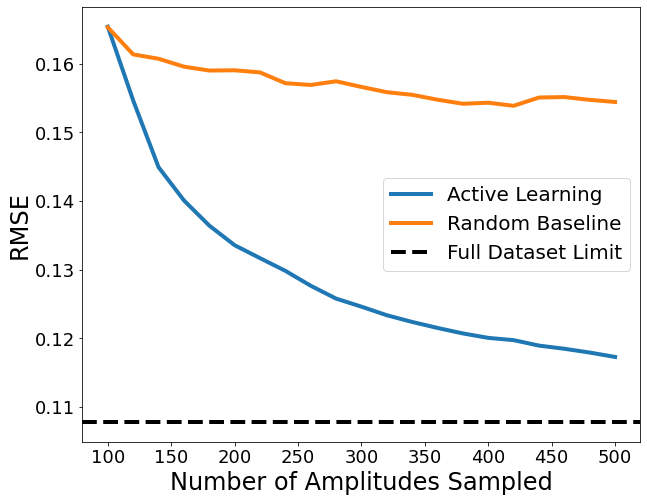

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(num_samples, np.mean(performance_stack, axis=0), label='Active Learning', linewidth=4)
# plt.plot(num_samples, np.mean(performance_stack2, axis=0), label='Active Learning, 0% Exploit', linewidth=4)
plt.plot(num_samples, np.mean(performance_stack_random, axis=0), label='Random Baseline', linewidth=4)
plt.axhline(performance_full, c='k', linestyle='--', label='Full Dataset Limit', linewidth=4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Amplitudes Sampled', fontsize=24)
# plt.ylabel(r'McFadden Pseudo $R^2$', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)